# Mapping Chemical Space with UMAP
source: https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb#scrollTo=dzmJAwfiAi6k  

This notebook walks you through creating a 2D visualization of a chemical dataset with UMAP, using the Blood Brain Barrier Permeability (BBBP) dataset from [MoleculeNet](http://moleculenet.ai/datasets-1). We show you how to install the relevant packages, embed your smiles as [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t), then reduce those high-dimensional vectors down to 2 dimensions with both Dataset-Specific and Dataset-Agnostic embeddings. We also include PCA and T-SNE embeddings for comparison.  

Clustering using UMAP is an example of **unsupervised** machine learning since the data is first clustered without knowing its label and then labeled for visualisation.


### Import libraries and data
Here all necessary libraries are imported and the necessary data is fetched. Also helper functions are set up.

In [1]:
from typing import List

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
import sklearn
import umap
import hdbscan

from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [3]:
def get_largest_fragment_from_smiles(s: str):
    mol = rdkit.Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return rdkit.Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = rdkit.Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

## Embed BBBP with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [4]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("data/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()
pd.DataFrame(bbbp).head()

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin


### Compute ECFP Descriptors

In [5]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### Embed with UMAP

In [6]:
%%time
umap_reducer = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
umap_embedding = umap_reducer.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = umap_embedding[:,0], umap_embedding[:,1]
pd.DataFrame(bbbp).head()

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 23.2 s
Wall time: 20.5 s


,smiles,permeable,name,UMAP_0,UMAP_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,11.035966,9.684184
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.969448,9.469379
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.101414,5.695937
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.533725,6.751961
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,6.121430,2.745245


### Embed with PCA

In [7]:
%%time
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:,0], X_pca[:,1]
pd.DataFrame(bbbp).head()

CPU times: total: 484 ms
Wall time: 91.8 ms


,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,11.035966,9.684184,-0.884478,0.820100
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.969448,9.469379,-0.141915,0.399368
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.101414,5.695937,0.196490,-0.384803
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.533725,6.751961,-0.607416,-0.262893
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,6.121430,2.745245,0.121057,1.925180


### Embed with t-SNE

In [8]:
%%time
tsne = sklearn.manifold.TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]
pd.DataFrame(bbbp).head()

CPU times: total: 44.3 s
Wall time: 5.01 s


,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,11.035966,9.684184,-0.884478,0.820100,-32.791016,-5.772398
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.969448,9.469379,-0.141915,0.399368,-28.147175,-23.418627
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.101414,5.695937,0.196490,-0.384803,-25.441963,-37.496513
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.533725,6.751961,-0.607416,-0.262893,-35.785625,-27.583471
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,6.121430,2.745245,0.121057,1.925180,-66.342697,14.206311


### Visualize the dataset embeddedings

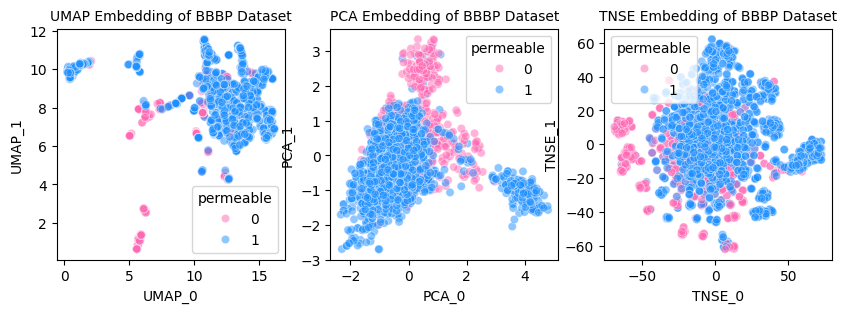

In [9]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i, method in enumerate(["UMAP", "PCA", "TNSE"]):
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette,
                    ax=ax[i])
    ax[i].set_title(f"{method} Embedding of BBBP Dataset", fontsize=10)

## Embedding in global Chem dataset

In [10]:
# Read in data from MoleculeNet
chembl = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/chembl_sparse.csv.gz", compression='gzip')

# Sample a random 10k
chembl_sample = chembl.sample(n=10000)

pd.DataFrame(chembl_sample).head()

,smiles,CHEMBL1075051,CHEMBL1075104,CHEMBL1075145,CHEMBL1075189,CHEMBL1075228,CHEMBL1075284,CHEMBL1075319,CHEMBL1163101,CHEMBL1163116,...,CHEMBL6084,CHEMBL6136,CHEMBL6137,CHEMBL6140,CHEMBL6141,CHEMBL6145,CHEMBL6154,CHEMBL6164,CHEMBL6166,CHEMBL6184
103387,CCNC(=O)N1CCCC12CCCN(C2)c3ncnc4[nH]ccc34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20580,O=C1\C(=C\c2ccc(cc2)N3CCCC3)\CC/C/1=C\c4ccc(cc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75113,CC(C)(C)OC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149052,CCC1(C)SC(=NC1=O)NC2CCCCCC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149777,CCC(=O)n1cc2C[C@@]3(C)[C@@H](CC[C@]4(C)[C@@H]3...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
%%time
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(chembl_sample["smiles"])

# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]

CPU times: total: 12.5 s
Wall time: 13 s


In [12]:
%%time
umap_model_global = umap.UMAP(metric = "jaccard",
                               n_neighbors = 25,
                               n_components = 2,
                               low_memory = False,
                               min_dist = 0.001)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_0"], chembl_sample["UMAP_1"] = X_umap_global[:,0], X_umap_global[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 1min 2s
Wall time: 20.6 s


In [13]:
%%time
X_umap_bbbp = umap_model_global.transform(ecfp_descriptors)
bbbp["UMAP_0 (global)"], bbbp["UMAP_1 (global)"] = X_umap_bbbp[:,0], X_umap_bbbp[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: total: 19.5 s
Wall time: 18.4 s


In [14]:
pd.DataFrame(bbbp).head()

,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,UMAP_0 (global),UMAP_1 (global)
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,11.035966,9.684184,-0.884478,0.820100,-32.791016,-5.772398,0.382065,1.018771
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.969448,9.469379,-0.141915,0.399368,-28.147175,-23.418627,0.458644,-0.287514
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.101414,5.695937,0.196490,-0.384803,-25.441963,-37.496513,2.434210,3.620266
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.533725,6.751961,-0.607416,-0.262893,-35.785625,-27.583471,-0.389708,2.539834
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,6.121430,2.745245,0.121057,1.925180,-66.342697,14.206311,1.929226,2.374106


Text(0.5, 1.0, 'Global UMAP Embedding of BBBP Dataset')

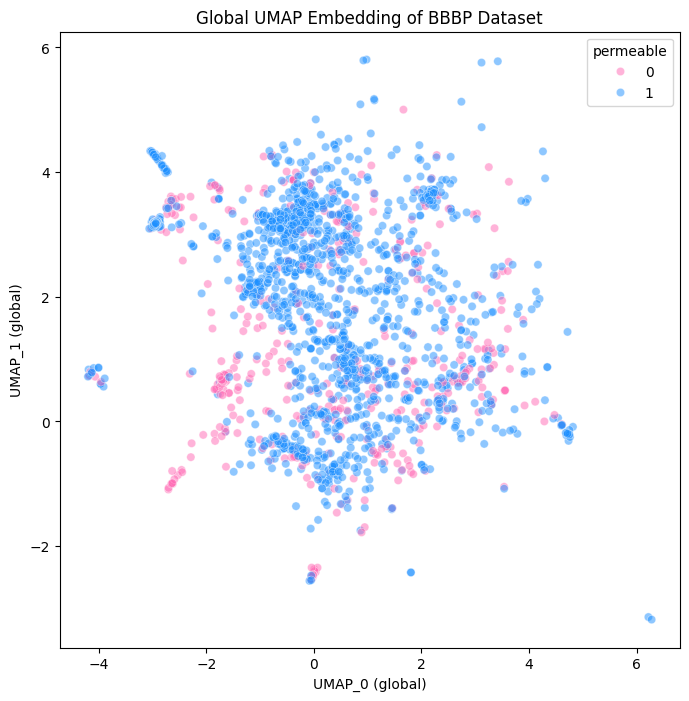

In [15]:
# visualise global umap from bbbp
plt.figure(figsize=(8,8))
sns.scatterplot(data=bbbp,
                x="UMAP_0 (global)",
                y="UMAP_1 (global)",
                hue="permeable",
                alpha=0.5,
                palette=palette)
plt.title("Global UMAP Embedding of BBBP Dataset")
